In [1]:
import pandas as pd
import numpy as np
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# for training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# for optimize
from skopt import gp_minimize, Optimizer
from skopt.space import Space, Integer, Real

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# custom packages
from bayes_opt import custom_minimize, resume_optimize
from agent import AgentBase

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from model import model

%load_ext autoreload
%autoreload 2


In [2]:
# meta config
random_seed = 2022

In [3]:
# space = Space((Integer(1, 12), Real(0.001, 10, prior="log-uniform", base=10)))
space = [[-25, 25], [-25, 25]]
x0 = [(24, 24)]
n_calls = 40
n_random_starts = 5

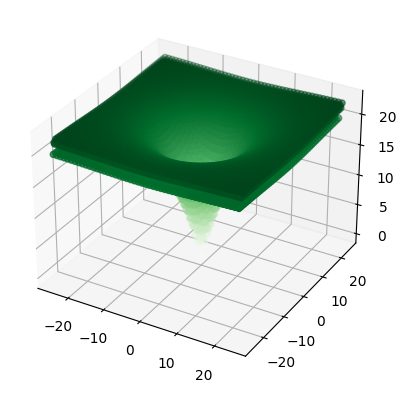

In [4]:
# visualize the graph
nx = np.arange(space[0][0], space[0][1], 0.5)
ny = np.arange(space[1][0], space[1][1], 0.5)
X, Y = np.meshgrid(nx, ny)
f = np.array([model((x, y)) for x, y in zip(X,Y)])

ax = plt.axes(projection='3d')

ax.scatter3D(X, Y, f, c=f, cmap='Greens')
plt.savefig("./figs/objective_ackley.pdf", bbox_inches="tight", dpi=300, format="pdf")

In [5]:
agent_a = AgentBase(dim=0, random_seed=random_seed)
agent_b = AgentBase(dim=1, random_seed=random_seed)

In [6]:
res, optimizer = agent_a.initialize_model(
                            model,
                            space,
                            x0,
                            initial_point_generator="grid",
                            acq_func="EI",      # the acquisition function
                            n_random_starts=n_random_starts,         # the number of evaluations of f
                        )

In [7]:
# params
records_f = res.func_vals
rounds = 5
budget_a = budget_b = (n_calls - n_random_starts) // rounds // 2
res_resume_b = res
res_resume_a = res

"""
We are going to make agent B free-ride here
"""

for _ in range(rounds):
    # Agent A iterates
    agent_a.punish_count = 0
    other_dim = agent_b.dim
    other_val = res_resume_b.x[other_dim]

    res_resume_a_next, optimizer, xs_a, ys_a = agent_a.update(
                                        model,
                                        budget_a,
                                        res_resume_b,
                                        optimizer,
                                        other_dim,
                                        other_val
                                        )
    print(other_val, xs_a)
    # Agent B iterates
    # agent_b.punish_count = 0
    # other_dim = agent_a.dim
    # other_val = res_resume_a.x[other_dim]
    #
    # res_resume_b_next, optimizer, xs_b, ys_b = agent_a.update(
    #                                     model,
    #                                     budget_b,
    #                                     res_resume_a,
    #                                     optimizer,
    #                                     other_dim,
    #                                     other_val
    #                                     )
    #
    res_resume_b_next = res_resume_a
    ys_b = ys_a


    # check whether to punish
    ys_star = min(min(ys_a), min(ys_b))
    r_star = min(min(ys_a), min(ys_b)) - min(records_f)
    r_f = min(ys_a) - min(records_f)


    # update params
    res_resume_a = res_resume_a_next
    res_resume_b = res_resume_b_next
    records_f = np.concatenate([records_f, [ys_star]])

-8 [[-8, -8], [25, -8], [2, -8]]
-8 [[-1, -8], [0, -8], [0, -8]]
-8 [[0, -8], [0, -8], [0, -8]]
-8 [[0, -8], [0, -8], [0, -8]]
-8 [[0, -8], [0, -8], [0, -8]]


In [8]:
# params
records_star = res.func_vals
rounds = 5
budget_a = budget_b = (n_calls - n_random_starts) // rounds // 2
res_resume_b = res
res_resume_a = res

ys_a = []
ys_b = []
res_resume_a_next = res_resume_a
res_resume_b_next = res_resume_b

agent_a.punish_count = 0
agent_b.punish_count = 0

for round in range(rounds):
    # Agent A iterates
    if not agent_a.need_punish:
        other_dim = agent_b.dim
        other_val = res_resume_b.x[other_dim]

        res_resume_a_next, optimizer, xs_a, ys_a = agent_a.update(
                                            model,
                                            budget_a,
                                            res_resume_b,
                                            optimizer,
                                            other_dim,
                                            other_val
                                            )

    # if not agent_b.need_punish:
    #     # Agent B iterates
    #     other_dim = agent_a.dim
    #     other_val = res_resume_a.x[other_dim]
    #
    #     res_resume_b_next, optimizer, xs_b, ys_b = agent_b.update(
    #                                         model,
    #                                         budget_b,
    #                                         res_resume_a,
    #                                         optimizer,
    #                                         other_dim,
    #                                         other_val
    #                                         )
    res_resume_b_next = res_resume_a
    ys_b = ys_a

    if agent_a.need_punish:
        res_resume_a_next = res_resume_b
        ys_a = ys_b
        agent_a.punish_count -= 1
    #
    # if agent_b.need_punish:
    #     res_resume_b_next = res_resume_a
    #     ys_b = ys_a
    #     agent_b.punish_count -= 1

    # check whether to punish
    ys_star = min(np.concatenate([ys_a, ys_b]))
    r_star = min(records_star) - min(np.concatenate([ys_a, ys_b, records_star])) - 1.0
    r_f = min(records_star) - min(np.concatenate([ys_a, records_star]))
    if r_star - r_f < 0.5:
        print(f"punish at round {round}: ", r_star, r_f)
        agent_a.punish_count = agent_a.punish(0.75, r_f, r_star)
        print("punish_count update:", agent_a.punish_count)



    # update params
    res_resume_a = res_resume_a_next
    res_resume_b = res_resume_b_next
    records_star = np.concatenate([records_star, [ys_star]])

punish at round 0:  1.413884234179621 2.413884234179621
punish_count update: 1
punish at round 1:  -1.0 0.0
punish_count update: 999999
punish at round 2:  -1.0 0.0
punish_count update: 999999
punish at round 3:  -1.0 0.0
punish_count update: 999999
punish at round 4:  -1.0 0.0
punish_count update: 999999


In [14]:
# params
records_star = res.func_vals
rounds = 5
budget_a = budget_b = (n_calls - n_random_starts) // rounds // 2
res_resume_b = res
res_resume_a = res

ys_a = []
ys_b = []
res_resume_a_next = res_resume_a
res_resume_b_next = res_resume_b

agent_a.punish_count = 0
agent_b.punish_count = 0

for _ in range(rounds):
    # Agent A iterates
    other_dim = agent_b.dim
    other_val = res_resume_b.x[other_dim]

    res_resume_a_next, optimizer, xs_a, ys_a = agent_a.update(
                                        model,
                                        budget_a,
                                        res_resume_b,
                                        optimizer,
                                        other_dim,
                                        other_val
                                        )

    # Agent B iterates
    other_dim = agent_a.dim
    other_val = res_resume_a.x[other_dim]

    res_resume_b_next, optimizer, xs_b, ys_b = agent_b.update(
                                        model,
                                        budget_b,
                                        res_resume_a,
                                        optimizer,
                                        other_dim,
                                        other_val
                                        )

    # if agent_a.need_punish:
    #     res_resume_a_next = res_resume_b
    #     ys_a = ys_b
    #     agent_a.punish_count -= 1
    #
    # if agent_b.need_punish:
    #     res_resume_b_next = res_resume_a
    #     ys_b = ys_a
    #     agent_b.punish_count -= 1

    # check whether to punish
    ys_star = min(np.concatenate([ys_a, ys_b]))
    r_star = min(records_star) - min(np.concatenate([ys_a, ys_b, records_star])) - 1.0
    r_f = min(records_star) - min(np.concatenate([ys_a, records_star]))
    # if r_star - r_f < 0.5:
    #     print("punish: ", r_star, r_f)
    #     agent_a.punish_count = agent_a.punish(0.75, r_f, r_star)
    #     print("punish_count update:", agent_a.punish_count)



    # update params
    res_resume_a = res_resume_a_next
    res_resume_b = res_resume_b_next
    records_star = np.concatenate([records_star, [ys_star]])

In [10]:
best_f = np.array([min(records_f[:i]) for i in range(1,len(records_f))])
best_star = np.array([min(records_star[:i]) for i in range(1,len(records_star))])

In [11]:
from plot_utils import set_up_plotting
set_up_plotting()

<module 'matplotlib.pyplot' from '/Users/zhouzijian/miniconda3/envs/paf/lib/python3.9/site-packages/matplotlib/pyplot.py'>

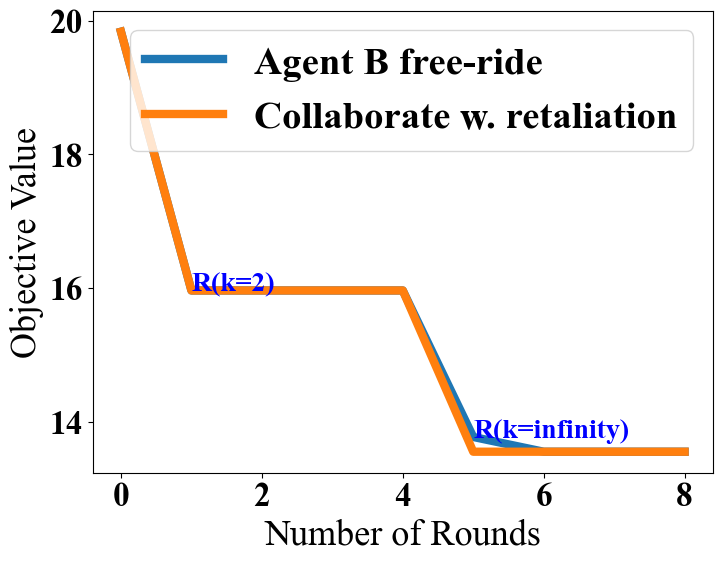

In [14]:
# compare the two approaches
plt.figure(figsize=(8, 6))

plt.plot(best_f, label="Agent B free-ride")
plt.plot(best_star, label="Collaborate w. retaliation")
plt.legend(fontsize=28)
plt.xlabel("Number of Rounds")
plt.ylabel("Objective Value")

plt.annotate("R(k=2)", (1, best_f[1]), c="blue", fontsize=20)
plt.annotate("R(k=infinity)", (5, best_f[5]), c="blue", fontsize=20)

plt.savefig("./figs/free_ride_retaliation.pdf", dpi=300, bbox_inches="tight", format="pdf")